<a href="https://colab.research.google.com/github/Starrysmh/MARK5828-AdvertisingAnalytics-Project/blob/main/7_Regression_signalchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requirements :
1. Merged Data (Instagram Data +Google CV Data + Opencv Data)
2. Week 2 Helpers
3. Instagram Data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns; sns.set()
from google.colab import files
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print('Please upload the week2_helper python file')
files.upload()

Please upload the week2_helper python file


Saving week2_helpers.py to week2_helpers.py


{'week2_helpers.py': b'"""\r\nSpecial Utility Functions for MARK5828 Week 2 Tutorial Content. The functions saved here are unnecessary for the students to learn, but they can read if they are curious.\r\nAuthor: James Lin\r\nSpecial Thanks: Daniel-Han Chan\r\n"""\r\n\r\nimport itertools\r\nfrom scipy.linalg.blas import ssyrk\r\nfrom scipy.linalg.lapack import spotrf, sposv\r\nimport numpy as np\r\nimport pandas as pd\r\n\r\nimport urllib.parse\r\nimport requests\r\n\r\ndef convert_to_seconds(time_str):\r\n    h, m, s = time_str.split(":")\r\n    return int(h) * 3600 + int(m) * 60 + round(float(s))\r\n\r\ndef get_source_language_v2(data):\r\n    return data["videos"][0]["insights"]["sourceLanguage"]\r\n\r\ndef get_video_duration_v2(data):\r\n    return data["summarizedInsights"]["duration"]["seconds"]\r\n\r\ndef get_faces_v2(data):\r\n    face_names = []\r\n    face_duration = []\r\n\r\n    for i, face in enumerate(data["summarizedInsights"]["faces"]):\r\n        face_names.append(face[

In [3]:
from week2_helpers import variance_inflation_factor

In [4]:
def file_reader():
  
  uploaded_file=files.upload()
  uploaded_file=list(uploaded_file.keys())[0]
  if uploaded_file.endswith('csv'):
    data=pd.read_csv(uploaded_file)
  else:
    data=pd.read_excel(uploaded_file)
  return data

In [5]:
print('Please upload the merged data')
merged_data=file_reader()

Please upload the merged data


Saving regression_data_signalchain.csv to regression_data_signalchain.csv


In [6]:
merged_data.head()

,file,likeCount,desc_len,pubDate,repost,Colorfulness_Picture,Saturation_Picture,Contrast_Picture,Clarity_Picture,Brightness_Picture,Warm Hue_Picture,joy_faces,sorrow_faces,surprise_faces,anger_faces,YesFinalInstrument,yesPerson
0,2,90,421,2017-08-27T21:48:54.000Z,0,10,115.02,50.81,1.00,39.76,0.01,0,0,0,0,0,0
1,3,75,415,2017-09-08T03:24:14.000Z,0,9,112.29,40.62,1.00,34.41,0.01,0,0,0,0,0,0
2,4,48,505,2017-08-08T02:33:39.000Z,0,3,30.90,44.82,1.00,31.21,0.16,0,0,0,0,0,0
3,5,28,129,2014-09-11T09:55:56.000Z,0,42,47.21,65.18,0.99,177.92,0.52,0,0,0,0,1,0
4,6,58,62,2017-09-12T22:01:55.000Z,0,10,115.80,47.49,1.00,38.01,0.01,0,0,0,0,0,0


In [7]:
print('Please upload the instagram data')
insta_data=file_reader()

Please upload the instagram data


Saving signalchain.csv to signalchain.csv


In [8]:
insta_data.head()

,postUrl,description,commentCount,likeCount,location,locationId,pubDate,likedByViewer,isSidecar,type,caption,profileUrl,username,fullName,taggedFullName1,taggedUsername1,imgUrl,postId,timestamp,query,sidePostUrl,taggedFullName2,taggedUsername2,videoUrl,viewCount,taggedFullName3,taggedUsername3,taggedFullName4,taggedUsername4,taggedFullName5,taggedUsername5,taggedFullName6,taggedUsername6,taggedFullName7,taggedUsername7,taggedFullName8,taggedUsername8,taggedFullName9,taggedUsername9,taggedFullName10,taggedUsername10,taggedFullName11,taggedUsername11,taggedFullName12,taggedUsername12,taggedFullName13,taggedUsername13,taggedFullName14,taggedUsername14,taggedFullName15,taggedUsername15,taggedFullName16,taggedUsername16
0,https://www.instagram.com/p/BYUBpTsgG7Q/,...and what are they?\n.\n#80tape #boutiqueeff...,111,90,NaN,NaN,2017-08-27T21:48:54.000Z,NaN,NaN,Photo,NaN,https://www.instagram.com/signalchainmusic/,signalchainmusic,S I G N A L ?????? C H A I N,NaN,NaN,https://scontent-lga3-2.cdninstagram.com/v/t51...,1.590900e+18,2021-06-27T15:31:24.273Z,https://www.instagram.com/signalchainmusic/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.instagram.com/p/BYw8xAWgIgc/,...and how does it take your particular pedals...,67,75,NaN,NaN,2017-09-08T03:24:14.000Z,NaN,NaN,Photo,NaN,https://www.instagram.com/signalchainmusic/,signalchainmusic,S I G N A L ?????? C H A I N,NaN,NaN,https://scontent-lga3-2.cdninstagram.com/v/t51...,1.599050e+18,2021-06-27T15:31:24.273Z,https://www.instagram.com/signalchainmusic/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.instagram.com/p/BXhCVabgj2j/,Mine is David Gilmour's extended solo at the e...,66,48,NaN,NaN,2017-08-08T02:33:39.000Z,NaN,NaN,Photo,NaN,https://www.instagram.com/signalchainmusic/,signalchainmusic,S I G N A L ?????? C H A I N,NaN,NaN,https://scontent-lga3-2.cdninstagram.com/v/t51...,1.576550e+18,2021-06-27T15:31:24.274Z,https://www.instagram.com/signalchainmusic/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.instagram.com/p/szQvgyNpkF/,We want to know! What was your very first peda...,63,28,NaN,NaN,2014-09-11T09:55:56.000Z,NaN,NaN,Photo,NaN,https://www.instagram.com/signalchainmusic/,signalchainmusic,S I G N A L ?????? C H A I N,NaN,NaN,https://scontent-lga3-2.cdninstagram.com/v/t51...,8.070620e+17,2021-06-27T15:32:10.050Z,https://www.instagram.com/signalchainmusic/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.instagram.com/p/BY9P2ruA1CL/,"...come on daisy chainers, 'fess up... ???? \n...",59,58,NaN,NaN,2017-09-12T22:01:55.000Z,NaN,NaN,Photo,NaN,https://www.instagram.com/signalchainmusic/,signalchainmusic,S I G N A L ?????? C H A I N,NaN,NaN,https://scontent-lga3-2.cdninstagram.com/v/t51...,1.602510e+18,2021-06-27T15:31:24.273Z,https://www.instagram.com/signalchainmusic/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract Features from Timestamp to account for the effect to time on the no.of likes.

In [16]:
def extract_datetime_features(df,col_name):
  df=df[[col_name]]
  df[col_name]=pd.to_datetime(df[col_name])
  df['month']=df[col_name].apply(lambda x:x.month_name())
  df['day']=df[col_name].apply(lambda x:x.day_name())
  df['year']=df[col_name].apply(lambda x:x.year)
  df['year_month']=df.year.apply(lambda x:str(x))+'_'+df.month.apply(lambda x:str(x))
  df['hour']=df[col_name].apply(lambda x:x.hour)
  df['file']=df.index+2
  df.drop([col_name,'year','month'],axis=1,inplace=True)
  df=pd.get_dummies(df,columns=['year_month','day','hour'],drop_first=False)
  return df


In [17]:
date_features=extract_datetime_features(df=insta_data,col_name='pubDate')
col_name='pubDate'

In [18]:
date_features.head()

,file,year_month_2014_August,year_month_2014_December,year_month_2014_November,year_month_2014_October,year_month_2014_September,year_month_2015_April,year_month_2015_August,year_month_2015_December,year_month_2015_February,year_month_2015_January,year_month_2015_July,year_month_2015_June,year_month_2015_March,year_month_2015_May,year_month_2015_November,year_month_2015_October,year_month_2015_September,year_month_2016_April,year_month_2016_August,year_month_2016_December,year_month_2016_February,year_month_2016_January,year_month_2016_July,year_month_2016_June,year_month_2016_March,year_month_2016_May,year_month_2016_November,year_month_2016_October,year_month_2016_September,year_month_2017_April,year_month_2017_August,year_month_2017_December,year_month_2017_February,year_month_2017_January,year_month_2017_July,year_month_2017_June,year_month_2017_March,year_month_2017_May,year_month_2017_November,...,year_month_2020_November,year_month_2020_October,year_month_2020_September,year_month_2021_April,year_month_2021_February,year_month_2021_January,year_month_2021_June,year_month_2021_March,year_month_2021_May,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [19]:
insta_data['pubDate']=pd.to_datetime(insta_data['pubDate'])
insta_data['month']=insta_data[col_name].apply(lambda x:x.month_name())
insta_data['day']=insta_data[col_name].apply(lambda x:x.day_name())
insta_data['year']=insta_data[col_name].apply(lambda x:x.year)
insta_data['year_month']=insta_data.year.apply(lambda x:str(x))+'_'+insta_data.month.apply(lambda x:str(x))
insta_data['hour']=insta_data[col_name].apply(lambda x:x.hour)

In [20]:
insta_data.groupby('year_month').likeCount.mean().sort_values()

year_month
2014_August        38.080000
2014_September     47.157143
2019_December      57.540000
2020_June          60.741379
2019_November      64.000000
                     ...    
2018_October      210.083333
2018_August       212.200000
2019_May          217.000000
2019_March        233.375000
2019_April        352.578947
Name: likeCount, Length: 83, dtype: float64

In [21]:
insta_data.groupby('day').likeCount.mean().sort_values()

day
Friday        98.063457
Thursday     110.035124
Wednesday    111.618661
Tuesday      111.889925
Monday       128.955128
Saturday     130.755682
Sunday       146.450758
Name: likeCount, dtype: float64

In [22]:
insta_data.groupby('hour').likeCount.mean().sort_values()

hour
19     81.600000
17     88.500000
18     92.333333
16     98.000000
13    103.272727
14    103.666667
3     106.861111
0     110.893048
22    111.331731
10    112.976744
20    113.175258
23    113.529412
1     113.649038
2     114.356877
21    115.353293
4     117.870229
12    118.721311
9     118.873874
6     120.015228
5     121.000000
11    126.785714
7     131.645161
8     134.172932
15    144.400000
Name: likeCount, dtype: float64

In [23]:
reg_data=merged_data.copy()
reg_data=reg_data.merge(right=date_features)

Setting References and dropping linearly dependent variables

Please note that these columns we are dropping are only based on this data. We will have to change the column names for a different set of data points. Other than the 'file' column we will have to change all the column names depending on the data.


In [24]:
reg_data.drop(['file','sorrow_faces',
               'pubDate'],axis=1,inplace=True)

Let us look at the distribution of the target Variable.

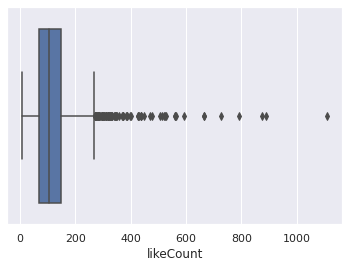

In [25]:
sns.boxplot(reg_data['likeCount'])

Approach 1: Let us drop the outliers and build a regression model

In [26]:
reg_data_subset=reg_data[reg_data.likeCount<=3000]

In [27]:
Y=reg_data_subset['likeCount']
X=reg_data_subset.drop(['likeCount'],axis=1).astype(float)

X=sm.add_constant(X)
model=sm.OLS(Y,X)
results=model.fit()

In [28]:
vif = variance_inflation_factor(X)
vif_store=vif.drop('const',axis=0)

In [29]:
vif_store.sort_values(by='vif',ascending=False)

,vif
hour_23,inf
day_Wednesday,inf
year_month_2014_September,2.533991e+09
year_month_2015_July,2.166932e+09
year_month_2014_November,1.894563e+09
...,...
hour_19,1.106296e+00
hour_15,1.100628e+00
hour_18,1.085128e+00
hour_16,1.057579e+00


In [30]:
vif_store.sort_values('vif',ascending=False)
df_coeffs = pd.DataFrame({"Coefficients": results.params, "p": results.pvalues, "vif": vif["vif"]})
if 'const' in df_coeffs.index:
    df_coeffs = df_coeffs.drop("const", axis=0)
df_coeffs_sorted = df_coeffs.reindex(df_coeffs["p"].sort_values(ascending=True).index)


In [31]:
print(f'There are about {Counter(df_coeffs.p<=0.05)[True]} significant variables')
print(f'There are about {Counter(df_coeffs.vif>=5)[True]} variables with variance inflation factor of more than 5')

There are about 49 significant variables
There are about 85 variables with variance inflation factor of more than 5


In [33]:
print(df_coeffs_sorted[df_coeffs_sorted.p<=0.05])

                           Coefficients             p           vif
year_month_2014_September    -74.221060  1.333984e-15  2.533991e+09
year_month_2019_April        214.828064  1.545477e-15  2.482898e+08
YesFinalInstrument            30.965598  1.008558e-12  1.161547e+00
year_month_2020_June         -74.194071  3.104112e-09  1.300911e+09
year_month_2019_March        111.933649  1.497531e-08  5.041871e+08
year_month_2020_January      -67.762219  6.678076e-08  1.271885e+09
year_month_2020_February     -76.884912  9.633790e-08  9.644934e+08
year_month_2020_July         -58.965367  3.980320e-07  1.545427e+09
year_month_2019_June          75.782490  5.132364e-07  8.798864e+08
year_month_2014_August       -77.512995  8.515260e-07  7.982099e+08
year_month_2020_May          -62.846584  1.069380e-06  1.228858e+09
year_month_2020_March        -64.940301  1.922777e-06  1.073042e+09
desc_len                       0.031004  5.008595e-06  1.418014e+00
year_month_2019_November     -60.744362  7.31232

Let us drop these variables with high VIF and see how it affects the model

In [34]:
df_vif = X.loc[:, vif["vif"] <= 5]
X = sm.add_constant(df_vif.astype(float)) 
model = sm.OLS(Y, X)
results = model.fit()

In [35]:
vif = variance_inflation_factor(X)
vif_store=vif.drop('const',axis=0)
vif_store.sort_values('vif',ascending=False)
df_coeffs = pd.DataFrame({"Coefficients": results.params, "p": results.pvalues, "vif": vif["vif"]})
if 'const' in df_coeffs.index:
    df_coeffs = df_coeffs.drop("const", axis=0)
df_coeffs_sorted = df_coeffs.reindex(df_coeffs["p"].sort_values(ascending=True).index)


In [36]:
print(f'There are about {Counter(df_coeffs.p<=0.05)[True]} significant variables')
print(f'There are about {Counter(df_coeffs.vif>=5)[True]} variables with variance inflation factor of more than 5')

There are about 7 significant variables
There are about 0 variables with variance inflation factor of more than 5


In [37]:
print(df_coeffs_sorted[df_coeffs_sorted.p<=0.05])

                    Coefficients             p       vif
desc_len                0.078699  3.145194e-32  1.057526
day_Sunday             40.121609  3.927841e-08  1.475285
YesFinalInstrument     22.495602  1.747065e-06  1.098118
day_Saturday           24.388873  2.971649e-04  1.604714
day_Monday             19.715435  3.743754e-03  1.551804
Brightness_Picture     -0.153782  5.592286e-03  2.292571
Clarity_Picture        87.845024  3.911035e-02  1.148755


Approach 2: Let us further reduce try to shrink the variance of the target variable by taking a log transformation.

In [38]:
Y = np.log(reg_data_subset["likeCount"]+1)
X = reg_data_subset.drop(['likeCount'], axis=1).astype(float)
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()

In [39]:
vif = variance_inflation_factor(X)
vif_store=vif.drop('const',axis=0)

In [40]:
vif_store.sort_values('vif',ascending=False)
df_coeffs = pd.DataFrame({"Coefficients": results.params, "p": results.pvalues, "vif": vif["vif"]})
if 'const' in df_coeffs.index:
    df_coeffs = df_coeffs.drop("const", axis=0)
df_coeffs_sorted = df_coeffs.reindex(df_coeffs["p"].sort_values(ascending=True).index)


In [41]:
print(f'There are about {Counter(df_coeffs.p<=0.05)[True]} significant variables')
print(f'There are about {Counter(df_coeffs.vif>=5)[True]} variables with variance inflation factor of more than 5')

There are about 85 significant variables
There are about 85 variables with variance inflation factor of more than 5


In [42]:
print(df_coeffs_sorted[df_coeffs_sorted.p<=0.05])

                           Coefficients             p           vif
year_month_2014_September     -0.824340  1.023407e-40  2.533991e+09
day_Saturday                   0.561461  4.859043e-38  1.695398e+00
day_Sunday                     0.547467  1.487989e-35  1.576321e+00
day_Monday                     0.473775  1.041088e-29  1.649529e+00
day_Tuesday                    0.418678  9.246318e-26  1.873040e+00
...                                 ...           ...           ...
hour_10                        0.140561  2.865211e-02  1.701238e+00
year_month_2016_December       0.194421  2.883821e-02  1.089138e+09
hour_15                        0.576108  3.106540e-02  1.100628e+00
year_month_2020_November      -0.198173  3.298477e-02  9.943491e+08
year_month_2015_June           0.173265  3.611461e-02  1.315316e+09

[85 rows x 3 columns]


In [43]:
df_vif = X.loc[:, vif["vif"] <= 5]
X = sm.add_constant(df_vif.astype(float)) 
model = sm.OLS(Y, X)
results = model.fit()

In [44]:
vif=variance_inflation_factor(X)
vif = variance_inflation_factor(X)
vif_store=vif.drop('const',axis=0)
vif_store.sort_values('vif',ascending=False)
df_coeffs = pd.DataFrame({"Coefficients": results.params, "p": results.pvalues, "vif": vif["vif"]})
if 'const' in df_coeffs.index:
    df_coeffs = df_coeffs.drop("const", axis=0)
df_coeffs_sorted = df_coeffs.reindex(df_coeffs["p"].sort_values(ascending=True).index)


In [45]:
print(f'There are about {Counter(df_coeffs.p<=0.05)[True]} significant variables')
print(f'There are about {Counter(df_coeffs.vif>=5)[True]} variables with variance inflation factor of more than 5')

There are about 9 significant variables
There are about 0 variables with variance inflation factor of more than 5


In [46]:
print(df_coeffs_sorted[df_coeffs_sorted.p<=0.05])

                    Coefficients             p       vif
desc_len                0.000696  1.340839e-48  1.057526
YesFinalInstrument      0.221602  3.006591e-11  1.098118
day_Sunday              0.274048  1.086603e-07  1.475285
day_Saturday            0.150719  1.551369e-03  1.604714
Brightness_Picture     -0.001094  5.270091e-03  2.292571
Clarity_Picture         0.729160  1.540599e-02  1.148755
Contrast_Picture        0.002054  2.509474e-02  1.071781
day_Monday              0.106075  2.723606e-02  1.551804
Saturation_Picture     -0.001056  3.933132e-02  3.336059
